In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns

file_path = r'C:\Users\nacho\OneDrive - University of Birmingham\DATA SCIENCE\Summer Project\all_player_data.csv'
df = pd.read_csv(file_path)


C:\Users\nacho\anaconda\envs\notebook-6.1.5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Best for this role: n_neighbors=5, min_dist=0.0, k=4, silhouette=0.473


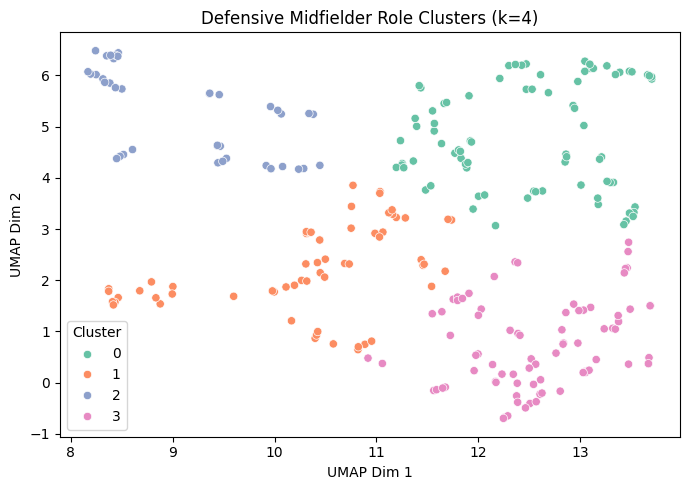

In [2]:
df["projected_y"] = df["average_position_y"].apply(lambda y: 80 - y if y < 40 else y)

target_positions = ['Center Defensive Midfield', 'Left Defensive Midfield', 'Right Defensive Midfield']
group = df[df["most_played_position"].isin(target_positions)].copy()

import warnings
warnings.filterwarnings("ignore")




usable_features = [
    # Passing
    'passes_per_90', 'pass_accuracy', 'progressive_passes_per_90',
    #'progressive_pass_accuracy', 
    'long_passes_per_90', 
    #'long_pass_accuracy', 
    'key_passes_per_90', 'crosses_per_90', #'cross_accuracy', #'assists_per_90', 
    'passes_received_per_90',
    
    #shots
    'shots_per_90', #'shots_on_target_per_90', 
    #'shot_accuracy', #'goals_per_90', 
    #'first_time_shots_per_90', 
    'xg_per_90', #'headers_per_90', 
    #'shots_outside_box_per_90',
    
    #dribbles
    'progressive_runs_per_90', 'fouls_won_per_90', 'dribbles_per_90', 'dribble_success_rate',
    #'successful_dribbles_per_90', 
    
    # Defense
    'interceptions_per_90', 'blocks_per_90', 'clearances_per_90',
    'dribbled_past_per_90', 'pressures_per_90', 'ball_recoveries_per_90', 

    # Duels / Aerials / Physicality
    'duels_per_90', 'duels_won_per_90', #'duel_success_rate',
    'fouls_made_per_90',

    # Positioning
    'touches_per_90', 'average_position_x', 'projected_y',
]

X = group[usable_features].dropna()
if len(X) < 10:
    print("Not enough valid rows for clustering.")
else:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    best_score = -1
    best_params, best_embedding, best_k, best_labels = None, None, None, None

    for n in [5, 10, 15, 30, 50]:
        for d in [0.0, 0.05, 0.1, 0.3, 0.5, 0.7]:
            reducer = umap.UMAP(n_neighbors=n, min_dist=d, n_components=2, random_state=42)
            X_umap = reducer.fit_transform(X_scaled)

            for k in range(2, 6):
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                labels = kmeans.fit_predict(X_umap)
                score = silhouette_score(X_umap, labels)
                if score > best_score:
                    best_score = score
                    best_params = (n, d)
                    best_embedding = X_umap
                    best_k = k
                    best_labels = labels

    print(f"✅ Best for this role: n_neighbors={best_params[0]}, min_dist={best_params[1]}, k={best_k}, silhouette={best_score:.3f}")

    plt.figure(figsize=(7, 5))
    sns.scatterplot(x=best_embedding[:, 0], y=best_embedding[:, 1], hue=best_labels, palette='Set2')
    plt.title(f"Defensive Midfielder Role Clusters (k={best_k})")
    plt.xlabel("UMAP Dim 1")
    plt.ylabel("UMAP Dim 2")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()


In [3]:
# Add cluster labels to the original filtered dataframe (aligned by index)
group = group.loc[X.index].copy()  # ensure index alignment
group['cluster'] = best_labels

# Calculate average stats per cluster
cluster_means = group.groupby('cluster')[usable_features].mean()

# Set option to display all columns
pd.set_option('display.max_columns', None)

print("\n=== Average Stats by Cluster ===")
print(cluster_means)

# (Optional) Reset to default after printing if you want
pd.reset_option('display.max_columns')



=== Average Stats by Cluster ===
         passes_per_90  pass_accuracy  progressive_passes_per_90  \
cluster                                                            
0            32.366313      79.300123                   9.427435   
1            36.523951      84.067086                   9.857070   
2            45.487594      80.379872                  13.958209   
3            29.132413      80.745564                   8.425022   

         long_passes_per_90  key_passes_per_90  crosses_per_90  \
cluster                                                          
0                  3.455634           0.416503        0.323166   
1                  3.287177           0.349321        0.172809   
2                  6.783050           0.947746        0.743835   
3                  2.961999           0.295257        0.196261   

         passes_received_per_90  shots_per_90  xg_per_90  \
cluster                                                    
0                     27.651641      0.6

In [4]:
for cluster_id, cluster_data in group.groupby('cluster'):
    print(f"\nCluster {cluster_id}:")
    for idx, row in cluster_data.iterrows():
        print(f"Player: {idx}, Name: {row['name']}, position {row['most_played_position']}")


Cluster 0:
Player: 19, Name: Gonzalo Escalante, position Right Defensive Midfield
Player: 27, Name: Sebastián Carlos Cristóforo Pepe, position Left Defensive Midfield
Player: 29, Name: Roque Mesa Quevedo, position Right Defensive Midfield
Player: 62, Name: Pedro Mosquera Parada, position Left Defensive Midfield
Player: 71, Name: Mehdi Lacen, position Left Defensive Midfield
Player: 110, Name: Víctor Sánchez Mata, position Right Defensive Midfield
Player: 117, Name: José Luis García del Pozo, position Left Defensive Midfield
Player: 135, Name: Sergio Álvarez Díaz, position Right Defensive Midfield
Player: 141, Name: Manuel Trigueros Muñoz, position Right Defensive Midfield
Player: 174, Name: Petros Matheus dos Santos Araújo, position Right Defensive Midfield
Player: 176, Name: Daniel Ceballos Fernández, position Left Defensive Midfield
Player: 185, Name: Alejandro Bergantiños García, position Right Defensive Midfield
Player: 191, Name: Carlos Henrique Casimiro, position Center Defensiv

In [5]:
role_map = {
    0: "Ball Winning Midfielder",
    1: "Positional Midfielder",
    2: "Deep Playmaker",
    3: "Anchor Man"
}

group = group.loc[X.index].copy()
group["role"] = [role_map[label] for label in best_labels]
group.head()

final = group.drop(columns = ['cluster', 'projected_y'])
final

final.to_csv('cdm_roles.csv', index=False)

✅ Best for this role: n_neighbors=15, min_dist=0.0, k=3, silhouette=0.461


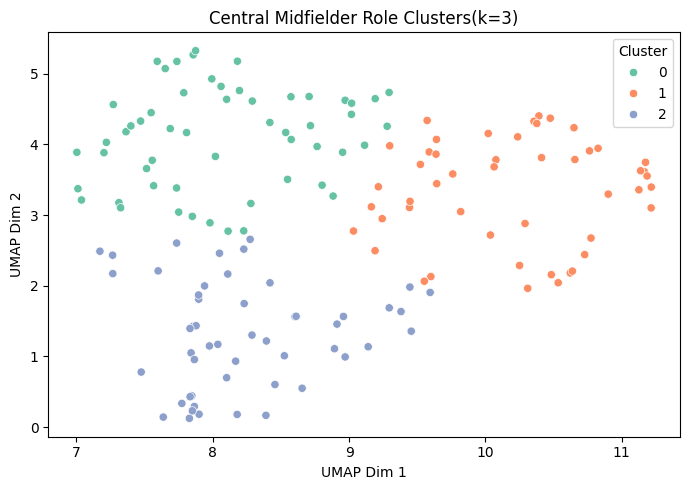

In [19]:

target_positions = ['Left Center Midfield','Center Midfield', 'Right Center Midfield']
group = df[df["most_played_position"].isin(target_positions)].copy()

import warnings
warnings.filterwarnings("ignore")




usable_features = [
    # Passing
    'passes_per_90', 'pass_accuracy', 'progressive_passes_per_90',
    #'progressive_pass_accuracy', 
    'long_passes_per_90', 
    #'long_pass_accuracy', 
    'key_passes_per_90', 'crosses_per_90', #'cross_accuracy', #'assists_per_90', 
    'passes_received_per_90',
    
    #shots
    'shots_per_90', #'shots_on_target_per_90', 
    #'shot_accuracy', #'goals_per_90', 
    #'first_time_shots_per_90', 
    'xg_per_90', #'headers_per_90', 
    'shots_outside_box_per_90',
    
    #dribbles
    'progressive_runs_per_90', 'fouls_won_per_90', 'dribbles_per_90', 'dribble_success_rate',
    #'successful_dribbles_per_90', 
    
    # Defense
    'interceptions_per_90', 'blocks_per_90', 'clearances_per_90',
    'dribbled_past_per_90', 'pressures_per_90', 'ball_recoveries_per_90', 

    # Duels / Aerials / Physicality
    'duels_per_90', 'duels_won_per_90', #'duel_success_rate',
    'fouls_made_per_90',

    # Positioning
    'touches_per_90', 'average_position_x', 'projected_y',
]

X = group[usable_features].dropna()
if len(X) < 10:
    print("Not enough valid rows for clustering.")
else:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    best_score = -1
    best_params, best_embedding, best_k, best_labels = None, None, None, None

    for n in [5, 10, 15, 30, 50]:
        for d in [0.0, 0.05, 0.1, 0.3, 0.5, 0.7]:
            reducer = umap.UMAP(n_neighbors=n, min_dist=d, n_components=2, random_state=42)
            X_umap = reducer.fit_transform(X_scaled)

            for k in range(2, 6):
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                labels = kmeans.fit_predict(X_umap)
                score = silhouette_score(X_umap, labels)
                if score > best_score:
                    best_score = score
                    best_params = (n, d)
                    best_embedding = X_umap
                    best_k = k
                    best_labels = labels

    print(f"✅ Best for this role: n_neighbors={best_params[0]}, min_dist={best_params[1]}, k={best_k}, silhouette={best_score:.3f}")

    plt.figure(figsize=(7, 5))
    sns.scatterplot(x=best_embedding[:, 0], y=best_embedding[:, 1], hue=best_labels, palette='Set2')
    plt.title(f"Central Midfielder Role Clusters(k={best_k})")
    plt.xlabel("UMAP Dim 1")
    plt.ylabel("UMAP Dim 2")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()


In [7]:
# Add cluster labels to the original filtered dataframe (aligned by index)
group = group.loc[X.index].copy()  # ensure index alignment
group['cluster'] = best_labels

# Calculate average stats per cluster
cluster_means = group.groupby('cluster')[usable_features].mean()

# Set option to display all columns
pd.set_option('display.max_columns', None)

print("\n=== Average Stats by Cluster ===")
print(cluster_means)

# (Optional) Reset to default after printing if you want
pd.reset_option('display.max_columns')



=== Average Stats by Cluster ===
         passes_per_90  pass_accuracy  progressive_passes_per_90  \
cluster                                                            
0            30.079553      76.166559                   8.162041   
1            25.504657      79.069798                   6.578099   
2            43.911502      81.131433                  12.251598   

         long_passes_per_90  key_passes_per_90  crosses_per_90  \
cluster                                                          
0                  2.946066           0.588886        0.755467   
1                  2.269431           0.488177        0.397296   
2                  5.105860           0.988361        0.913562   

         passes_received_per_90  shots_per_90  xg_per_90  \
cluster                                                    
0                     30.619482      0.878053   0.055804   
1                     24.972472      0.683420   0.061798   
2                     42.126404      0.974193   0.0730

In [8]:
for cluster_id, cluster_data in group.groupby('cluster'):
    print(f"\nCluster {cluster_id}:")
    for idx, row in cluster_data.iterrows():
        print(f"Player: {idx}, Name: {row['name']}, position {row['most_played_position']}")


Cluster 0:
Player: 52, Name: Juan Emmanuel Culio, position Left Center Midfield
Player: 220, Name: Pedro Pablo Hernández, position Left Center Midfield
Player: 246, Name: André Filipe Tavares Gomes, position Left Center Midfield
Player: 252, Name: Danilo Barbosa da Silva, position Right Center Midfield
Player: 325, Name: Esteban Félix Granero Molina, position Right Center Midfield
Player: 418, Name: Arda Turan, position Left Center Midfield
Player: 424, Name: Harry Arter, position Left Center Midfield
Player: 442, Name: Dan Gosling, position Right Center Midfield
Player: 477, Name: Vurnon Anita, position Right Center Midfield
Player: 493, Name: Idrissa Gana Gueye, position Left Center Midfield
Player: 516, Name: Etienne Capoue, position Right Center Midfield
Player: 740, Name: Jack Frank Porteous Cork, position Right Center Midfield
Player: 804, Name: Cheik Ismaël Tioté, position Right Center Midfield
Player: 836, Name: Jasmin Kurtič, position Left Center Midfield
Player: 843, Name: E

In [9]:
role_map = {
    0: "Box to Box Midfielder",
    1: "Holding Midfielder",
    2: "Playmaker"
}

group = group.loc[X.index].copy()
group["role"] = [role_map[label] for label in best_labels]
group.head()

final = group.drop(columns = ['cluster', 'projected_y'])
final

final.to_csv('cm_roles.csv', index=False)

✅ Best for this role: n_neighbors=10, min_dist=0.1, k=3, silhouette=0.466


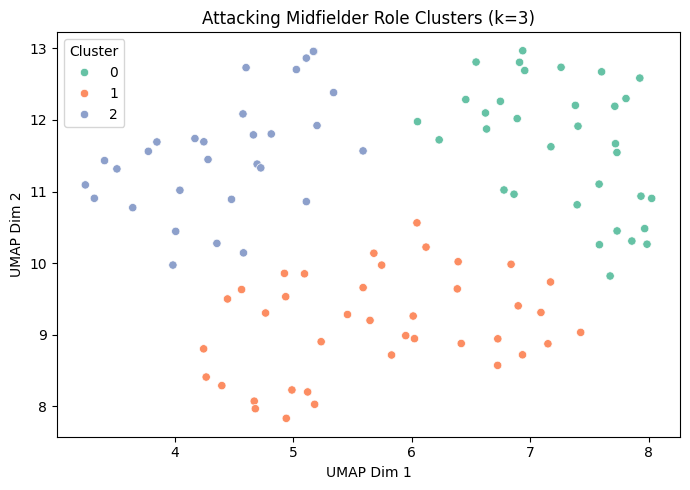

In [10]:
target_positions = ['Center Attacking Midfield', 'Left Attacking Midfield', 'Right Attacking Midfield']
group = df[df["most_played_position"].isin(target_positions)].copy()

import warnings
warnings.filterwarnings("ignore")




usable_features = [
    # Passing
    'passes_per_90', 'pass_accuracy', 'progressive_passes_per_90',
    #'progressive_pass_accuracy', 
    'long_passes_per_90', 
    #'long_pass_accuracy', 
    'key_passes_per_90', 'crosses_per_90', #'cross_accuracy', #'assists_per_90', 
    'passes_received_per_90',
    
    #shots
    'shots_per_90', #'shots_on_target_per_90', 
    #'shot_accuracy', #'goals_per_90', 
    #'first_time_shots_per_90', 
    'xg_per_90', #'headers_per_90', 
    'shots_outside_box_per_90',
    
    #dribbles
    'progressive_runs_per_90', 'fouls_won_per_90', 'dribbles_per_90', 'dribble_success_rate',
    #'successful_dribbles_per_90', 
    
    # Defense
    'interceptions_per_90', 'blocks_per_90', 'clearances_per_90',
    'dribbled_past_per_90', 'pressures_per_90', 'ball_recoveries_per_90', 

    # Duels / Aerials / Physicality
    'duels_per_90', 'duels_won_per_90', #'duel_success_rate',
    'fouls_made_per_90',

    # Positioning
    'touches_per_90', 'average_position_x', 'projected_y',
]

X = group[usable_features].dropna()
if len(X) < 10:
    print("Not enough valid rows for clustering.")
else:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    best_score = -1
    best_params, best_embedding, best_k, best_labels = None, None, None, None

    for n in [5, 10, 15, 30, 50]:
        for d in [0.0, 0.05, 0.1, 0.3, 0.5, 0.7]:
            reducer = umap.UMAP(n_neighbors=n, min_dist=d, n_components=2, random_state=42)
            X_umap = reducer.fit_transform(X_scaled)

            for k in range(2, 6):
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                labels = kmeans.fit_predict(X_umap)
                score = silhouette_score(X_umap, labels)
                if score > best_score:
                    best_score = score
                    best_params = (n, d)
                    best_embedding = X_umap
                    best_k = k
                    best_labels = labels

    print(f"✅ Best for this role: n_neighbors={best_params[0]}, min_dist={best_params[1]}, k={best_k}, silhouette={best_score:.3f}")

    plt.figure(figsize=(7, 5))
    sns.scatterplot(x=best_embedding[:, 0], y=best_embedding[:, 1], hue=best_labels, palette='Set2')
    plt.title(f"Attacking Midfielder Role Clusters (k={best_k})")
    plt.xlabel("UMAP Dim 1")
    plt.ylabel("UMAP Dim 2")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

In [11]:
# Add cluster labels to the original filtered dataframe (aligned by index)
group = group.loc[X.index].copy()  # ensure index alignment
group['cluster'] = best_labels

# Calculate average stats per cluster
cluster_means = group.groupby('cluster')[usable_features].mean()

# Set option to display all columns
pd.set_option('display.max_columns', None)

print("\n=== Average Stats by Cluster ===")
print(cluster_means)

# (Optional) Reset to default after printing if you want
pd.reset_option('display.max_columns')


=== Average Stats by Cluster ===
         passes_per_90  pass_accuracy  progressive_passes_per_90  \
cluster                                                            
0            32.623688      73.560857                   8.637283   
1            22.256119      74.177170                   5.530845   
2            34.434424      79.204821                   8.179147   

         long_passes_per_90  key_passes_per_90  crosses_per_90  \
cluster                                                          
0                  4.339992           1.131863        1.260180   
1                  1.706073           0.583178        0.484700   
2                  3.580044           1.186269        1.127085   

         passes_received_per_90  shots_per_90  xg_per_90  \
cluster                                                    
0                     36.988133      1.380737   0.114025   
1                     28.965929      1.000717   0.109443   
2                     41.494646      1.417009   0.1330

In [12]:
for cluster_id, cluster_data in group.groupby('cluster'):
    print(f"\nCluster {cluster_id}:")
    for idx, row in cluster_data.iterrows():
        print(f"Player: {idx}, Name: {row['name']}, position {row['most_played_position']}")


Cluster 0:
Player: 112, Name: Marco Asensio Willemsen, position Center Attacking Midfield
Player: 305, Name: Éver Maximiliano David Banega, position Center Attacking Midfield
Player: 318, Name: Rubén Rochina Naixes, position Center Attacking Midfield
Player: 367, Name: Francisco Medina Luna, position Center Attacking Midfield
Player: 390, Name: Javier Márquez Moreno, position Center Attacking Midfield
Player: 396, Name: Sergio Canales Madrazo, position Center Attacking Midfield
Player: 398, Name: Patrick Ebert, position Center Attacking Midfield
Player: 567, Name: Bamidele Alli, position Center Attacking Midfield
Player: 599, Name: Jason Puncheon, position Center Attacking Midfield
Player: 637, Name: Adam David Lallana, position Center Attacking Midfield
Player: 646, Name: Roberto Firmino Barbosa de Oliveira, position Center Attacking Midfield
Player: 667, Name: Ander Herrera Agüera, position Center Attacking Midfield
Player: 703, Name: Oscar dos Santos Emboaba Júnior, position Center

In [13]:
role_map = {
    0: "Advanced Playmaker",
    1: "False 10",
    2: "Second Striker"
}

group = group.loc[X.index].copy()
group["role"] = [role_map[label] for label in best_labels]
group.head()

final = group.drop(columns = ['cluster', 'projected_y'])
final

final.to_csv('cam_roles.csv', index=False)

✅ Best for this role: n_neighbors=5, min_dist=0.0, k=2, silhouette=0.568


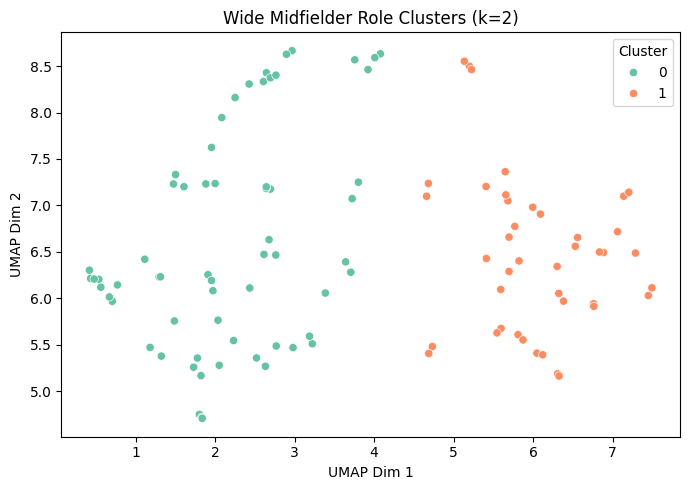

In [14]:
target_positions = ['Left Midfield', 'Right Midfield']
group = df[df["most_played_position"].isin(target_positions)].copy()

import warnings
warnings.filterwarnings("ignore")




usable_features = [
    # Passing
    'passes_per_90', #'pass_accuracy', 
    'progressive_passes_per_90',
    #'progressive_pass_accuracy', 
    'long_passes_per_90', 
    #'long_pass_accuracy', 
    'key_passes_per_90', #'crosses_per_90', 
    'cross_accuracy', #'assists_per_90', 
    #'passes_received_per_90',
    
    #shots
    'shots_per_90', #'shots_on_target_per_90', 
    #'shot_accuracy', 
    'goals_per_90', 
    #'first_time_shots_per_90', 
    'xg_per_90', #'headers_per_90', 
    'shots_outside_box_per_90',
    
    #dribbles
    'progressive_runs_per_90', 'fouls_won_per_90', 
    'dribbles_per_90', 'dribble_success_rate',
    #'successful_dribbles_per_90', 
    
    # Defense
    'interceptions_per_90', 'blocks_per_90', #'clearances_per_90',
    'dribbled_past_per_90', 'pressures_per_90', 'ball_recoveries_per_90', 

    # Duels / Aerials / Physicality
    'duels_per_90', 'duels_won_per_90', #'duel_success_rate',
    'fouls_made_per_90',

    # Positioning
    'touches_per_90',
    'average_position_x', 'projected_y',
]

X = group[usable_features].dropna()
if len(X) < 10:
    print("Not enough valid rows for clustering.")
else:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    best_score = -1
    best_params, best_embedding, best_k, best_labels = None, None, None, None

    for n in [5, 10, 15, 30, 50]:
        for d in [0.0, 0.05, 0.1, 0.3, 0.5, 0.7]:
            reducer = umap.UMAP(n_neighbors=n, min_dist=d, n_components=2, random_state=42)
            X_umap = reducer.fit_transform(X_scaled)

            for k in range(2, 6):
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                labels = kmeans.fit_predict(X_umap)
                score = silhouette_score(X_umap, labels)
                if score > best_score:
                    best_score = score
                    best_params = (n, d)
                    best_embedding = X_umap
                    best_k = k
                    best_labels = labels

    print(f"✅ Best for this role: n_neighbors={best_params[0]}, min_dist={best_params[1]}, k={best_k}, silhouette={best_score:.3f}")

    plt.figure(figsize=(7, 5))
    sns.scatterplot(x=best_embedding[:, 0], y=best_embedding[:, 1], hue=best_labels, palette='Set2')
    plt.title(f"Wide Midfielder Role Clusters (k={best_k})")
    plt.xlabel("UMAP Dim 1")
    plt.ylabel("UMAP Dim 2")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

In [15]:
# Add cluster labels to the original filtered dataframe (aligned by index)
group = group.loc[X.index].copy()  # ensure index alignment
group['cluster'] = best_labels

# Calculate average stats per cluster
cluster_means = group.groupby('cluster')[usable_features].mean()

# Set option to display all columns
pd.set_option('display.max_columns', None)

print("\n=== Average Stats by Cluster ===")
print(cluster_means)

# (Optional) Reset to default after printing if you want
pd.reset_option('display.max_columns')


=== Average Stats by Cluster ===
         passes_per_90  progressive_passes_per_90  long_passes_per_90  \
cluster                                                                 
0            28.239457                   6.879386            3.971136   
1            18.638234                   4.159693            2.027955   

         key_passes_per_90  cross_accuracy  shots_per_90  goals_per_90  \
cluster                                                                  
0                 1.040385       27.755407      1.347992      0.109925   
1                 0.593794       30.107879      0.867503      0.058981   

         xg_per_90  shots_outside_box_per_90  progressive_runs_per_90  \
cluster                                                                 
0         0.104658                  0.026048                 3.415545   
1         0.069318                  0.010830                 2.195047   

         fouls_won_per_90  dribbles_per_90  dribble_success_rate  \
cluster        

In [16]:
for cluster_id, cluster_data in group.groupby('cluster'):
    print(f"\nCluster {cluster_id}:")
    for idx, row in cluster_data.iterrows():
        print(f"Player: {idx}, Name: {row['name']}, position {row['most_played_position']}")


Cluster 0:
Player: 9, Name: José Luis Morales Nogales, position Left Midfield
Player: 82, Name: Juan Pablo Añor Acosta, position Right Midfield
Player: 89, Name: Gonzalo Castro Irizábal, position Left Midfield
Player: 99, Name: Sérgio Paulo Barbosa Valente, position Right Midfield
Player: 119, Name: Jerónimo Figueroa Cabrera, position Left Midfield
Player: 142, Name: Jonathan dos Santos Ramírez, position Right Midfield
Player: 143, Name: Samuel Castillejo Azuaga, position Left Midfield
Player: 148, Name: Denis Suárez Fernández, position Left Midfield
Player: 175, Name: Joaquín Sánchez Rodríguez, position Right Midfield
Player: 178, Name: Charly Musonda Junior, position Left Midfield
Player: 228, Name: Saúl Ñíguez Esclapez, position Right Midfield
Player: 229, Name: Jorge Resurrección Merodio, position Left Midfield
Player: 240, Name: Yannick Ferreira Carrasco, position Left Midfield
Player: 268, Name: Ángel Martín Correa, position Right Midfield
Player: 425, Name: Marc Albrighton, pos

In [17]:
role_map = {
    0: "Wide Playmaker",
    1: "Wide Supporter"
}

group = group.loc[X.index].copy()
group["role"] = [role_map[label] for label in best_labels]
group.head()

final = group.drop(columns = ['cluster', 'projected_y'])
final

final.to_csv('widemid_roles.csv', index=False)

In [18]:
final


,player_id,name,minutes,most_played_position,position,passes_per_90,pass_accuracy,progressive_passes_per_90,progressive_pass_accuracy,long_passes_per_90,...,collections_per_90,punches_per_90,sweeper_claims_per_90,sweeper_clears_per_90,save_percentage,smother_success_rate,collection_success_rate,punch_success_rate,sweeper_success_rate,role
9,6668,José Luis Morales Nogales,3873.33,Left Midfield,midfielder,23.282292,67.265469,6.482794,55.913978,3.392430,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wide Playmaker
39,6626,Mubarak Wakaso,1745.57,Left Midfield,midfielder,25.624868,79.275654,5.207468,59.405941,2.990427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wide Supporter
51,6608,Nabil El Zhar,2683.48,Right Midfield,midfielder,21.196357,77.848101,3.052007,62.637363,1.408619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wide Supporter
82,6563,Juan Pablo Añor Acosta,2506.65,Right Midfield,midfielder,24.558674,73.830409,6.067859,58.579882,2.405601,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wide Playmaker
89,6740,Gonzalo Castro Irizábal,2228.72,Left Midfield,midfielder,26.934743,62.068966,7.551420,48.128342,6.138052,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wide Playmaker
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,2991,Hervé Bazile,1956.12,Left Midfield,midfielder,18.817864,57.457213,4.508926,39.795918,4.462916,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wide Supporter
1956,310534,Louis Poggi,1083.78,Right Midfield,midfielder,12.705531,56.862745,3.986049,31.250000,2.823451,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wide Supporter
1960,23784,Nill De Pauw,891.87,Right Midfield,midfielder,15.237647,61.589404,4.036463,37.500000,2.522789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wide Supporter
1986,4900,Paul-Georges Ntep de Madiba,1243.22,Left Midfield,midfielder,30.115346,63.942308,7.022088,47.422680,3.764418,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wide Playmaker
